# Лабораторная работа №3: Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

## Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import simplefilter

simplefilter('ignore')

## Загрузка предобработанного в первой лабе датасета

In [2]:
data = pd.read_csv('laptop_price_preprocessed.csv')

In [3]:
data.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram_GB,OpSys,Weight_kg,Price_euros,ScreenType,...,ScreenRes,Cpu_type,Cpu_GHz,Gpu_producer,Gpu_model,Memory1_GB,Memory1_type,Memory2_GB,Memory2_type,Memory2
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,IPS Panel Retina Display,...,2560x1600,Intel Core i5,2.3,Intel,Iris Plus Graphics 640,128,SSD,0,-,-
1,2,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,-,...,1440x900,Intel Core i5,1.8,Intel,HD Graphics 6000,128,Flash Storage,0,-,-
2,3,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,...,1920x1080,Intel Core i5 7200U,2.5,Intel,HD Graphics 620,256,SSD,0,-,-
3,4,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,IPS Panel Retina Display,...,2880x1800,Intel Core i7,2.7,AMD,Radeon Pro 455,512,SSD,0,-,-
4,5,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,IPS Panel Retina Display,...,2560x1600,Intel Core i5,3.1,Intel,Iris Plus Graphics 650,256,SSD,0,-,-


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   laptop_ID     1250 non-null   int64  
 1   Company       1250 non-null   object 
 2   Product       1250 non-null   object 
 3   TypeName      1250 non-null   object 
 4   Inches        1250 non-null   float64
 5   Ram_GB        1250 non-null   int64  
 6   OpSys         1250 non-null   object 
 7   Weight_kg     1250 non-null   float64
 8   Price_euros   1250 non-null   float64
 9   ScreenType    1250 non-null   object 
 10  ScreenWidth   1250 non-null   int64  
 11  ScreenHeight  1250 non-null   int64  
 12  ScreenRes     1250 non-null   object 
 13  Cpu_type      1250 non-null   object 
 14  Cpu_GHz       1250 non-null   float64
 15  Gpu_producer  1250 non-null   object 
 16  Gpu_model     1250 non-null   object 
 17  Memory1_GB    1250 non-null   int64  
 18  Memory1_type  1250 non-null 

## Кодирование категориальных признаков

In [5]:
category_cols = ['Memory1_type', 'Memory2_type', 'Company', 'Product', 'TypeName', 'OpSys', 
                 'ScreenType', 'Cpu_type', 'Gpu_producer', 'Gpu_model']

print('Количество уникальных значений\n')
for col in category_cols:
    print(f'{col}: {data[col].unique().size}')

Количество уникальных значений

Memory1_type: 4
Memory2_type: 4
Company: 19
Product: 618
TypeName: 6
OpSys: 9
ScreenType: 21
Cpu_type: 93
Gpu_producer: 4
Gpu_model: 110


In [6]:
remove_cols = ['Product']

In [7]:
for col in remove_cols:
    category_cols.remove(col)
data = pd.get_dummies(data, columns=category_cols)

In [8]:
data.drop(remove_cols, axis=1, inplace=True)
data.drop(['laptop_ID', 'ScreenRes', 'Memory2'], axis=1, inplace=True)
data.describe()

,Inches,Ram_GB,Weight_kg,Price_euros,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,...,Gpu_model_Radeon R7 M440,Gpu_model_Radeon R7 M445,Gpu_model_Radeon R7 M460,Gpu_model_Radeon R7 M465,Gpu_model_Radeon R9 M385,Gpu_model_Radeon RX 540,Gpu_model_Radeon RX 550,Gpu_model_Radeon RX 560,Gpu_model_Radeon RX 580,Gpu_model_UHD Graphics 620
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,15.034880,8.443200,2.046152,1132.177480,1897.272000,1072.256000,2.303856,447.180800,174.675200,0.055200,...,0.002400,0.011200,0.001600,0.000800,0.000800,0.001600,0.003200,0.000800,0.004000,0.052000
std,1.416838,5.121929,0.669436,703.965444,491.854703,283.172078,0.502772,367.670259,411.340426,0.228462,...,0.048951,0.105278,0.039984,0.028284,0.028284,0.039984,0.056501,0.028284,0.063144,0.222116
min,10.100000,2.000000,0.690000,174.000000,1366.000000,768.000000,0.900000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,600.425000,1600.000000,900.000000,2.000000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,8.000000,2.040000,985.000000,1920.000000,1080.000000,2.500000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.600000,8.000000,2.310000,1489.747500,1920.000000,1080.000000,2.700000,512.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.400000,64.000000,4.700000,6099.000000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Разделение выборки на обучающую и тестовую

In [9]:
y = data['Price_euros']
X = data.drop('Price_euros', axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

## Масштабирование данных

In [10]:
scaler = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train.describe()

,Inches,Ram_GB,Weight_kg,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,Memory1_type_HDD,...,Gpu_model_Radeon R7 M440,Gpu_model_Radeon R7 M445,Gpu_model_Radeon R7 M460,Gpu_model_Radeon R7 M465,Gpu_model_Radeon R9 M385,Gpu_model_Radeon RX 540,Gpu_model_Radeon RX 550,Gpu_model_Radeon RX 560,Gpu_model_Radeon RX 580,Gpu_model_UHD Graphics 620
count,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,...,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000
mean,0.590967,0.103300,0.337162,0.214886,0.218279,0.518493,0.214407,0.084987,0.056000,0.296000,...,0.002286,0.009143,0.002286,0.001143,0.001143,0.002286,0.003429,0.001143,0.005714,0.044571
std,0.173292,0.085202,0.164937,0.203257,0.207356,0.188520,0.180521,0.199047,0.230053,0.456752,...,0.047782,0.095235,0.047782,0.033806,0.033806,0.047782,0.058487,0.033806,0.075420,0.206479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.469880,0.032258,0.201995,0.094584,0.094828,0.407407,0.118110,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.662651,0.096774,0.336658,0.223929,0.224138,0.592593,0.118110,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.662651,0.096774,0.401496,0.223929,0.224138,0.666667,0.244094,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Обучение KNN с произвольным k

In [11]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    
def print_cv_result(cv_model, x_test, y_test):
    print(f'Оптимизация метрики {cv_model.scoring}: {cv_model.best_score_}')
    print(f'Лучший параметр: {cv_model.best_params_}')
    print('Метрики на тестовом наборе')
    print_metrics(y_test, cv_model.predict(x_test))
    print()

In [12]:
base_k = 7
base_knn = KNeighborsRegressor(n_neighbors=base_k)
base_knn.fit(x_train, y_train)
y_pred_base = base_knn.predict(x_test)
print(f'Test metrics for KNN with k={base_k}\n')
print_metrics(y_test, y_pred_base)

Test metrics for KNN with k=7

R^2: 0.7722710180524757
MSE: 98607.68197025849
MAE: 218.48083428571428


## Кросс-валидация

In [13]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_values = [5, 10]

for cv in cv_values:
    print(f'Результаты кросс-валидации при cv={cv}\n')
    for metric in metrics:    
        params = {'n_neighbors': range(1, 30)}
        knn_cv = GridSearchCV(KNeighborsRegressor(), params, cv=cv, scoring=metric, n_jobs=-1)
        knn_cv.fit(x_train, y_train)
        print_cv_result(knn_cv, x_test, y_test)

Результаты кросс-валидации при cv=5

Оптимизация метрики r2: 0.7726372857710311
Лучший параметр: {'n_neighbors': 4}
Метрики на тестовом наборе
R^2: 0.7841876602937758
MSE: 93447.72183591667
MAE: 209.1155

Оптимизация метрики neg_mean_squared_error: -116355.60149814286
Лучший параметр: {'n_neighbors': 4}
Метрики на тестовом наборе
R^2: 0.7841876602937758
MSE: 93447.72183591667
MAE: 209.1155

Оптимизация метрики neg_mean_absolute_error: -223.9260514285714
Лучший параметр: {'n_neighbors': 4}
Метрики на тестовом наборе
R^2: 0.7841876602937758
MSE: 93447.72183591667
MAE: 209.1155

Результаты кросс-валидации при cv=10

Оптимизация метрики r2: 0.7792314885077024
Лучший параметр: {'n_neighbors': 4}
Метрики на тестовом наборе
R^2: 0.7841876602937758
MSE: 93447.72183591667
MAE: 209.1155

Оптимизация метрики neg_mean_squared_error: -112797.48419457053
Лучший параметр: {'n_neighbors': 4}
Метрики на тестовом наборе
R^2: 0.7841876602937758
MSE: 93447.72183591667
MAE: 209.1155

Оптимизация метрики ne

In [14]:
best_k = 4
y_pred_best = KNeighborsRegressor(n_neighbors=best_k).fit(x_train, y_train).predict(x_test)

## Сравнение исходной и оптимальной моделей

In [15]:
print('Basic model\n')
print_metrics(y_test, y_pred_base)
print('_______________________')
print('\nOptimal model\n')
print_metrics(y_test, y_pred_best)

Basic model

R^2: 0.7722710180524757
MSE: 98607.68197025849
MAE: 218.48083428571428
_______________________

Optimal model

R^2: 0.7841876602937758
MSE: 93447.72183591667
MAE: 209.1155


## Визуализация результатов оптимальной модели

In [16]:
res = pd.DataFrame({'y_test': y_test, 'y_pred_best': y_pred_best}).sort_values(by='y_test')
res.head()

,y_test,y_pred_best
1191,174.0,292.0000
1098,196.0,267.2250
31,199.0,313.2475
1081,209.0,325.0000
1243,209.0,285.9500


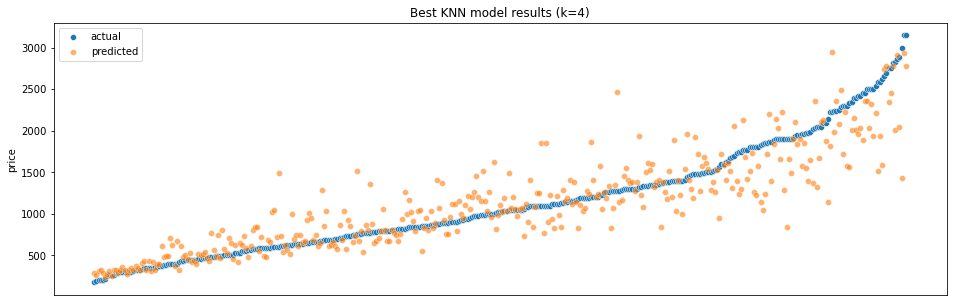

In [17]:
plt.figure(figsize=(16, 5))
sns.scatterplot(range(res.shape[0]), res['y_test'], label='actual')
sns.scatterplot(range(res.shape[0]), res['y_pred_best'], label='predicted', alpha=0.6)
plt.ylabel('price')
plt.xlabel('')
plt.title(f'Best KNN model results (k={best_k})')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()